In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
from  numpy.random import binomial as rbinom
from numpy.random import normal as rnorm
from numpy.random import uniform as runi
from numpy.random import gamma as gamma
from scipy.stats import norm,binom,t
import statistics
import itertools

## Question1 Stratified sampling
Out-of-the-money Call in a Black-Scholes model (i.e. lognormal ST). The parameters are: S0 = 50, r = 0.02, T = 0.5, σ = 0.25. The Call strike is K = 55.

The stratification will be on the underlying U’s, and the strata are $A1 = [0, 0.4], A2 = [0.4, 0.6], A3 =
[0.6, 0.8], A4 = [0.8, 1]$. So the corresponding pi’s are: $p1 = 0.4, p2 = p3 = p4 = 0.2 $.

We wish to use a total of M = 100 samples, split across the strata as N1 = 10,N2 = N3 = N4 =
30. Note that the split is not proportional to the pi, but this is ok: it only matters for estimating the conditional mean ˆµi and variance
σˆ2 in each strata

1. Give estimated $\hat{\mu_i},\hat{\sigma_i}$ for i=1,2,3,4
2. Give overall estimated option value $\hat{V}$
3. Give Standard error of $\hat{V}$, recall that it's weighted average of $\hat{\sigma^2}$, plus divede by M

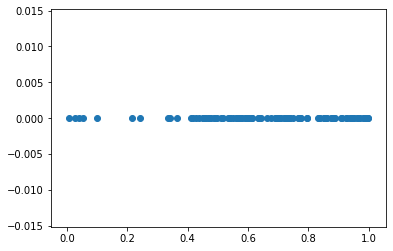

In [2]:
N1=10
N2=N3=N4=30
s0 = 50; r = 0.02; T = 0.5;sigma= 0.25;K=55

u = np.zeros(100)
s = np.zeros(100)
# generate the first strata random uniform value
u[0:10] = runi(0,0.4,size=10)
#generate the stock price for the 10 samples in the first strata
for i in range(10):
    s[i] = s0*math.exp((r-sigma**2/2)*T +sigma*math.sqrt(T)*norm.ppf(u[i]))
# generate 3 strata with 30 samples each
for k in range(3):
    u[(10+30*k):(10+30*(k+1))] = runi(0.4+0.2*k,0.6+0.2*k,size=30)
    for i in range(10,40):
        s[i+30*k] = s0*math.exp((r-sigma**2/2)*T +sigma*math.sqrt(T)*norm.ppf(u[i+30*k]))
plt.scatter(u, np.linspace(0,0,100))


In [3]:
# calculate payoff of each sample
payoff = np.zeros(100)
for i in range(100):
    payoff[i] = math.exp(-r*T)*max(s[i]-K,0)

mu=np.zeros(4)
sigma = np.zeros(4)
# calculate the first strata mean payoff and standard dev
mu[0]= np.mean(payoff[0:10])
sigma[0] = statistics.stdev(payoff[0:10])
# calculate the other stratas mean payoff and standard dev
for k in range(1,4):
    mu[k] = np.mean(payoff[10+30*(k-1):40+30*(k-1)])
    # comput sample standard deviation
    sigma[k]=statistics.stdev(payoff[10+30*(k-1):40+30*(k-1)])
print("mean payoff for each strat sampling", mu,"\n sigma for each strat samples",sigma)

mean payoff for each strat sampling [0.         0.         0.53891114 9.93213901] 
 sigma for each strat samples [0.         0.         0.77282979 6.02107697]


In [4]:
mean_payoff=sum(mu[1:4])*0.2 +0.4*mu[0]
print("option value is",mean_payoff)


option value is 2.0942100311981644


In [5]:
se = math.sqrt(sum(sigma[1:4]**2)*0.2 +0.4*sigma[0]**2)/math.sqrt(100)
print("standard error is", se)

standard error is 0.27147977382497235


## Problem 2: Monte Carlo for Aggregate Stop-Loss contracts

In [6]:
# cost of insurer 
def cost(y):
    """
    input: loss
    """
    co=0
    if y <1000 and y>0:
        c= 0
    if y<2500 and y>=1000:
        co= 1/2*(y-1000)
    if y>=2500:
        co = y-1750
    return co

In [7]:
def total_cost():
    """
    output： simulation of total cost 
    """
    N = rbinom(12,0.4)
    # m medium claims out of N claims
    m = rbinom(N,0.75)
    l = N-m
    y = np.zeros(N)
    for i in range(m):
        y[i] = gamma(4,1/0.02)
    for k in range(m,N):
        y[k]= gamma (5,1/0.01)
    total = sum(y)
    c = cost(total)
    return c

In [8]:
total_list=[]
for i in range(1000):
    total_list.append(total_cost())
print("Cost to insurer:",np.mean(total_list))

print("Probability the insurance pay nothing:",np.count_nonzero(np.array(total_list) == 0)/1000)

print("Probability the insurance pay more than 1000:",np.count_nonzero((np.array(total_list) >1000))/1000)

Cost to insurer: 214.5912820251377
Probability the insurance pay nothing: 0.358
Probability the insurance pay more than 1000: 0.024


## Problem 3
generate a plot of the efficient frontier for this model to cover the range $µV ∈ [0, 0.3].$ You should have at least 50 points on the frontier. Indicate which part of the frontier corresponds to portfolios without short-selling.
$0<\mu_V = 0.1*w+0.2*(1-w) = 0.2-0.1w<0.3 \iff w \in [-1,2]$

In [9]:
def muX(w,mu):
    """
    input: asset weights, returns
    output: portfolio mean
    """
    mu_v = np.dot(w ,mu.T)
    return mu_v
def sigmaX(w,cov):
    """
    input: asset weight, covariance matrix
    output: portfolio volatility
    """
    return math.sqrt(np.dot(np.dot(w,cov),w.T))


In [10]:
cov = np.matrix('0.16,0.1;0.1,0.25')
mu = np.array([0.1,0.2])

[]

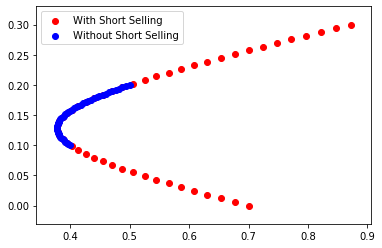

In [11]:
s=[]
s2 = s.copy()
m=[]
m2=m.copy()
# compute mu and sigma for 50 combination of portforlio 
for w in np.linspace(-1,2,50):
    w_list = np.array([w,1-w])
    s.append(sigmaX(w_list,cov))
    m.append(muX(w_list,mu))
# compute mu and sigma for 25 combination of portforlio without short selling
for w in np.linspace(0,1,50):
    w_list = np.array([w,1-w])
    s2.append(sigmaX(w_list,cov))
    m2.append(muX(w_list,mu))
plt.scatter(s,m, color="red",label="With Short Selling")
plt.scatter(s2,m2,color="blue",label="Without Short Selling")
plt.legend()

plt.plot()


In [12]:
# find the portfolio that max(muV-0.3sigma) by looking at 50 portfolio weight combination
w1 = np.array([w for w in np.linspace(-1,2,50)])
w2 =1-w1

#for w in np.linspace(-1,2,50):
w_list_store=[]
muV_store=[]
sigmaV_store =[]
indif_store =[]
for i in range(50):
    w_list = [w1[i],w2[i]]
    w_list_store.append(w_list)
    muV= muX(w_list,mu)
    muV_store.append(muV)
    sigmaV=sigmaX(np.array(w_list),cov)
    sigmaV_store.append(sigmaV)
    indif=muV-0.3*sigmaV
    indif_store.append(indif)
data = {'w1':w1,"w2":w2,"$\mu_V$": muV_store,"$\sigma_V$":sigmaV_store,"Indifference Line": indif_store}
pd.DataFrame(data)

,w1,w2,$\mu_V$,$\sigma_V$,Indifference Line
0,-1.000000,2.000000,0.300000,0.871780,0.038466
1,-0.938776,1.938776,0.293878,0.846585,0.039902
2,-0.877551,1.877551,0.287755,0.821575,0.041283
3,-0.816327,1.816327,0.281633,0.796768,0.042602
4,-0.755102,1.755102,0.275510,0.772184,0.043855
5,-0.693878,1.693878,0.269388,0.747844,0.045034
6,-0.632653,1.632653,0.263265,0.723774,0.046133
7,-0.571429,1.571429,0.257143,0.700000,0.047143
8,-0.510204,1.510204,0.251020,0.676554,0.048054
9,-0.448980,1.448980,0.244898,0.653472,0.048856


In [13]:
id_max = indif_store.index(max(indif_store))
print("Portfolio weights are:", w1[id_max],w2[id_max])

Portfolio weights are: -0.1428571428571429 1.1428571428571428


## Problem 4. 
Consider three stocks with the following rate of returns $m = [µ1, µ2, µ3] =[0.1 0.12 0.16]$ and covariance matrix 
$$
[ 0.09, -0.03,  0.  ]\\
        [-0.03,  0.16,  0.04]\\
        [ 0.  ,  0.04,  0.16]
$$

In [14]:

C=np.matrix([[ 0.09, -0.03,  0.  ],
        [-0.03,  0.16,  0.04],
        [ 0.  ,  0.04,  0.16]])
mu_list = np.matrix("0.1,0.12,0.16")
def minvariance(cov,number_of_assets):
        """
        input: covraince
        output: min variance weights
        """
        one = np.asmatrix(np.ones((1,number_of_assets)))
        w_min = np.dot(one,np.linalg.inv(cov))/np.dot(np.dot(one,np.linalg.inv(cov)),one.T)
        return np.asarray(w_min)
print("The weights the minimize total portfolio variance is:",minvariance(C,3))


The weights the minimize total portfolio variance is: [[0.53179191 0.30057803 0.16763006]]


In [17]:
print("The standard deviation associatted is:",sigmaX(minvariance(C,3),C))

The standard deviation associatted is: 0.19708863649596378


### Question4b 

### given mean portfolio return, find weights of assets


In [18]:
def effport(mu_v, mu_list, cov):
    one = np.asmatrix(np.ones((1,mu_list.shape[1])))
    aa = np.matrix("1,1;1,1",dtype=float)
    bb =np.matrix("1,1;1,1",dtype=float)
    cc = np.matrix("1,1;1,1",dtype=float)
    aa[0,1] = one*np.linalg.inv(cov)*mu_list.T
    aa[1,0] = mu_v
    aa[1,1] = mu_list * np.linalg.inv(cov)*mu_list.T
    
    bb[0,0]= one*np.linalg.inv(cov)*one.T
    bb[1,0]= mu_list * np.linalg.inv(cov)*one.T
    bb[1,1]= mu_v
    
    cc[0,0] = bb[0,0]
    cc[0,1] = aa[0,1]
    cc[1,0] = bb[1,0]
    cc[1,1] = aa[1,1]
    w = (np.linalg.det(aa)*one*np.linalg.inv(cov)+np.linalg.det(bb)*mu_list *np.linalg.inv(cov))/np.linalg.det(cc)
    return w

In [31]:
mu_v=0.15
w=effport(mu_v,mu_list,C)
print("portfolio with minimal variance under this constraint \n",w)

portfolio with minimal variance under this constraint 
 [[0.09134615 0.11298077 0.79567308]]


In [20]:
print("associated portfolio standard deviation \n",sigmaX(w,C))

associated portfolio standard deviation 
 0.33265756821739023


### Question 4c 
If the risk-free rate is rF = 0.04, find the market portfolio, together with its expected return and standard deviation.

In [23]:
one= np.asmatrix(np.ones((1,3)))
w = (mu_list -0.04*one)*np.linalg.inv(C)
w_norm=w/np.sum(w)
print("The market Portfolio is ",w_norm,"Expected return is", muX(w_norm,mu_list),"SD is",sigmaX(w_norm, C))


The market Portfolio is  [[0.42553191 0.25531915 0.31914894]] Expected return is [[0.12425532]] SD is 0.20742225713964152


### Question5a

In [25]:
mu=np.array([0.06,0.08,0.12])
cov = np.matrix('0.04,0.01,-0.01;0.01,0.09,0;-0.01,0,0.25')

In [26]:
s=[]
s2 = s.copy()
m=[]
m2=m.copy()

Mean return of Min Variance: [0.07243077]


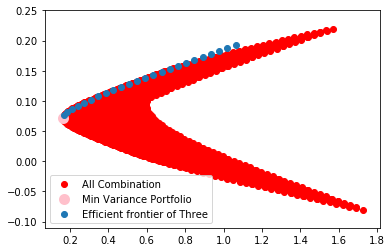

In [27]:
# All combination of three assets
for w1 in np.linspace(-1,2,50):
    for w2 in np.linspace(-1,2,50):
        w_list = np.array([w1,w2,1-w1-w2])
        s.append(sigmaX(w_list,cov))
        m.append(muX(w_list,mu))
plt.scatter(s,m, color="red",label="All Combination")


# find the min variance portfolio
w_minvar = minvariance(cov,3)
plt.scatter(sigmaX(w_minvar,cov),muX(w_minvar,mu),color = "PINK",linewidths=5, label ="Min Variance Portfolio")
mu_minv=muX(w_minvar,mu)
print("Mean return of Min Variance:",mu_minv)

# find the efficient frontier
def efficient_fron(mu_minv,mu,cov):
    """
    input: min_variance mu, mu list, covariance
    output: portfolio risk, return lists 
    """
    s_eff=[]
    mu_eff=[]
    for i in range (1,25):
        w=np.asarray(effport(mu_minv+i/200, np.asmatrix(mu), cov))
        s_eff.append(sigmaX(w,cov))
        mu_eff.append(list(muX(w,mu)))
    return s_eff, mu_eff

# plot efficient frontier of three assets portfolio
plt.scatter(efficient_fron(mu_minv,mu,cov)[0],efficient_fron(mu_minv,mu,cov)[1],label="Efficient frontier of Three")
plt.legend()


### 5b

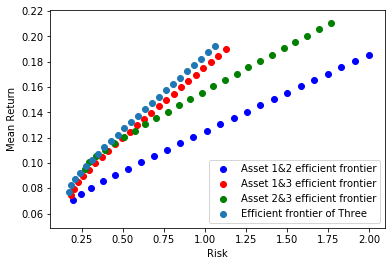

In [28]:
# 3 Combinations of two asset
m12,m13,m23=itertools.combinations(mu,2)
tuples = [m12,m13,m23]
m12, m13, m23 = np.asarray(tuples)

# Covariance of 3 combination of two-asset port
c12 = cov[0:2,0:2]
c13 = cov[0:3:2,0:3:2]
c23 = cov[1:3,1:3]

# plot asset 1 and 2 efficient frontier
w12_min =  minvariance(c12,2)
s,m = efficient_fron(muX(w12_min,m12), m12,c12)
plt.scatter(s,m,label="Asset 1&2 efficient frontier", color = "blue")

# plot asset 1 and 3 efficient frontier
w13_min =  minvariance(c13,2)
s2,m2 = efficient_fron(muX(w13_min,m13), m13,c13)
plt.scatter(s2,m2,label="Asset 1&3 efficient frontier", color = "red")

# plot asset 2 and 3 efficient frontier
w23_min =  minvariance(c23,2)
s3,m3 = efficient_fron(muX(w23_min,m23), m23,c23)
plt.scatter(s3,m3,label="Asset 2&3 efficient frontier", color = "green")

# plot all asset efficient frontier
plt.scatter(efficient_fron(mu_minv,mu,cov)[0],efficient_fron(mu_minv,mu,cov)[1],label="Efficient frontier of Three")

plt.xlabel("Risk")
plt.ylabel("Mean Return")
plt.legend()

In [29]:
# output 4 portfolios' risk and return 
data={"Portfolio":["M123","M12","M13","M23"],"Portfolio Weight": [w_minvar,w12_min,w13_min,w23_min],"$\mu$":[mu_minv,muX(w12_min,m12), muX(w13_min,m13),muX(w23_min,m23)], "$\sigma$": [sigmaX(w_minvar,cov),sigmaX(w12_min,c12),sigmaX(w13_min,c13),sigmaX(w23_min,c23)]}
pd.DataFrame(data)

,Portfolio,Portfolio Weight,$\mu$,$\sigma$
0,M123,"[[0.643076923076923, 0.2246153846153846, 0.132...",[0.07243076923076923],0.163236
1,M12,"[[0.7272727272727273, 0.27272727272727276]]",[0.06545454545454546],0.178377
2,M13,"[[0.8387096774193548, 0.16129032258064516]]",[0.0696774193548387],0.178705
3,M23,"[[0.7352941176470588, 0.2647058823529412]]",[0.09058823529411764],0.257248


c) Discuss how the 4 curves and the 4 min-variance portfolios look like relative to each other and
why.

1. For the 2-asset portfolio with higher return, the risk is higher. 
2. Comapred with the first two 2-asset portfolio, three-asset portfolio has lower riske and higher return. And it has the lowest risk.
3. Three-asset portfolio curves contained all other efficient portfolio curves.